<a href="https://colab.research.google.com/github/RPeleja/WorkML/blob/main/ProjetoML_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import seaborn as sb
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer


In [297]:
from google.colab import drive

# it will ask for your google drive credentiaals
drive.mount('/content/drive/', force_remount=True)

#global path variable
path="/content/drive/MyDrive/Colab Notebooks/ML/ProjetoML_WINE/"

Mounted at /content/drive/


In [298]:
# Dataset File Path
filePath_red = path + "winequality-red.csv"
filePath_white = path + "winequality-white.csv"
filePath_weather = path + "weather-porto-2024.csv"

df1 = pd.read_csv(filePath_red)
df1['type'] = 'red'
df2 = pd.read_csv(filePath_white)
df2['type'] = 'white'

weather_df = pd.read_csv(filePath_weather, delimiter=';')

wine_df = pd.concat([df1, df2], ignore_index=True)

print("Nr. rows - wines: ", len(wine_df))

Nr. rows - wines:  6497


In [299]:
# Filter for September and October - wine wascollected between September and October
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format='%d/%m/%Y %H:%M')
weather_filtered = weather_df[(weather_df['timestamp'].dt.month >= 9) & (weather_df['timestamp'].dt.month <= 10)]

# Generate random dates within the weather data range for the wine dataset
min_date = weather_filtered['timestamp'].min()
max_date = weather_filtered['timestamp'].max()
wine_df['timestamp'] = np.random.choice(pd.date_range(min_date, max_date), size=len(wine_df))

# Merge datasets on timestamp
df = pd.merge_asof(wine_df.sort_values('timestamp'),
                             weather_df.sort_values('timestamp'),
                             on='timestamp',
                             direction='nearest')

In [300]:
print("Nr. rows - df: ", len(df))

Nr. rows - df:  6497


In [301]:
# Check final dataset
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,name,barometricpressure,precipitation,relativehumidity,solarradiation,temperature,uv_index,uvindexmax,winddirection,windspeed
0,6.3,0.260,0.49,1.5,0.052,34.0,134.0,0.99240,2.99,0.61,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
1,7.2,0.210,0.36,15.7,0.045,68.0,183.0,0.99922,3.25,0.76,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
2,7.9,0.110,0.49,4.5,0.048,27.0,133.0,0.99460,3.24,0.42,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
3,8.2,0.180,0.49,1.1,0.033,28.0,81.0,0.99230,3.00,0.68,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816
4,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.99940,3.51,0.72,...,urn:ngsi-ld:WeatherObserved:porto:weather:weat...,NaN,0.0,0.89,0.0,14.5,NaN,0.0,226.0,1.78816


In [302]:
# Display basic information about the DataFrame
print(df.info())

# Display descriptive statistics for numerical features
print(df.describe())

print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fixed acidity         6497 non-null   float64       
 1   volatile acidity      6497 non-null   float64       
 2   citric acid           6497 non-null   float64       
 3   residual sugar        6497 non-null   float64       
 4   chlorides             6497 non-null   float64       
 5   free sulfur dioxide   6497 non-null   float64       
 6   total sulfur dioxide  6497 non-null   float64       
 7   density               6497 non-null   float64       
 8   pH                    6497 non-null   float64       
 9   sulphates             6497 non-null   float64       
 10  alcohol               6497 non-null   float64       
 11  quality               6497 non-null   int64         
 12  type                  6497 non-null   object        
 13  timestamp         

In [303]:
# Get the categorical variables from df
categorical_features = [feature for feature in df.columns if df[feature].dtype == object]
print(categorical_features)

['type', 'date_observed', 'time_observed', 'entity_id', 'entity_type', 'name']


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'timestamp', 'latitude', 'longitude', 'barometricpressure', 'precipitation', 'relativehumidity', 'solarradiation', 'temperature', 'uv_index', 'uvindexmax', 'winddirection', 'windspeed']


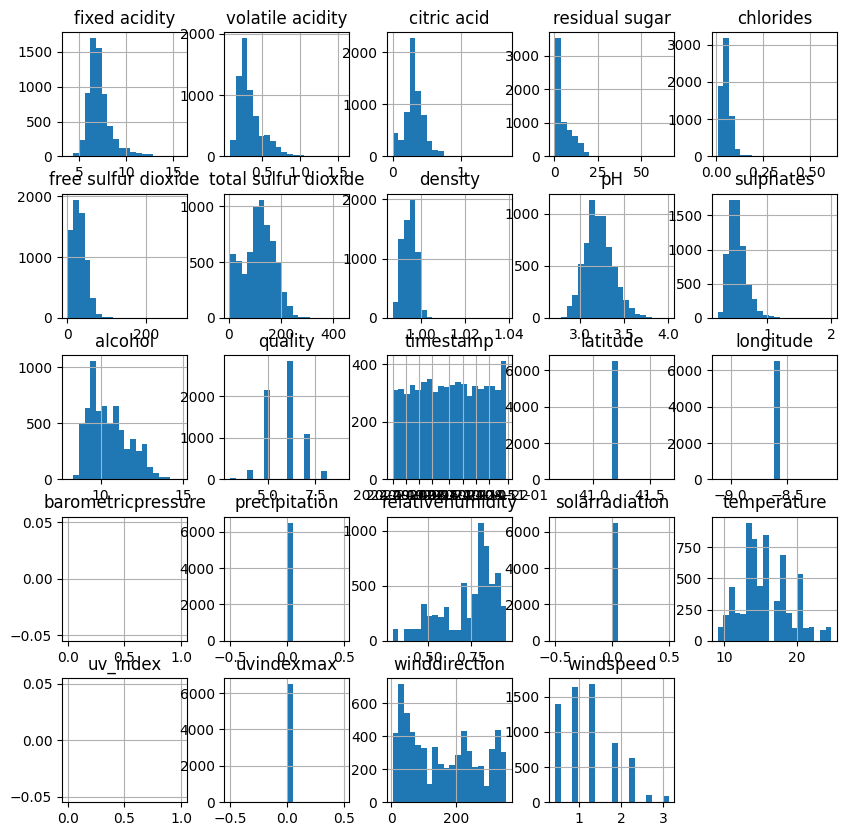

In [304]:
# Get the numerical variables from train_df
numerical_features = [feature for feature in df.columns if df[feature].dtype != object]
print(numerical_features)

df.hist(bins=20, figsize=(10, 10))
plt.show()

In [305]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


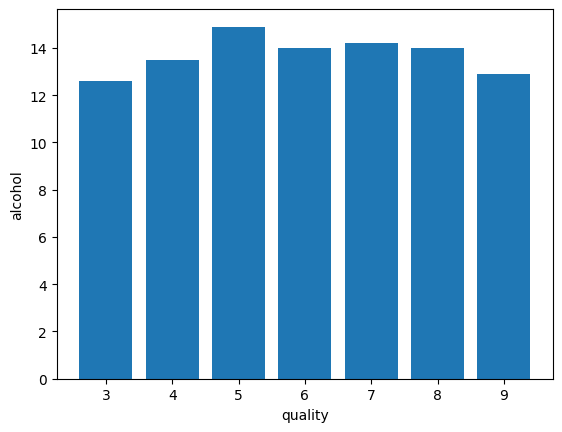

In [306]:
plt.bar(df['quality'], df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()


In [307]:
df.replace({'white': 1, 'red': 0}, inplace=True)

<ipython-input-307-e2600a577b5b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'white': 1, 'red': 0}, inplace=True)


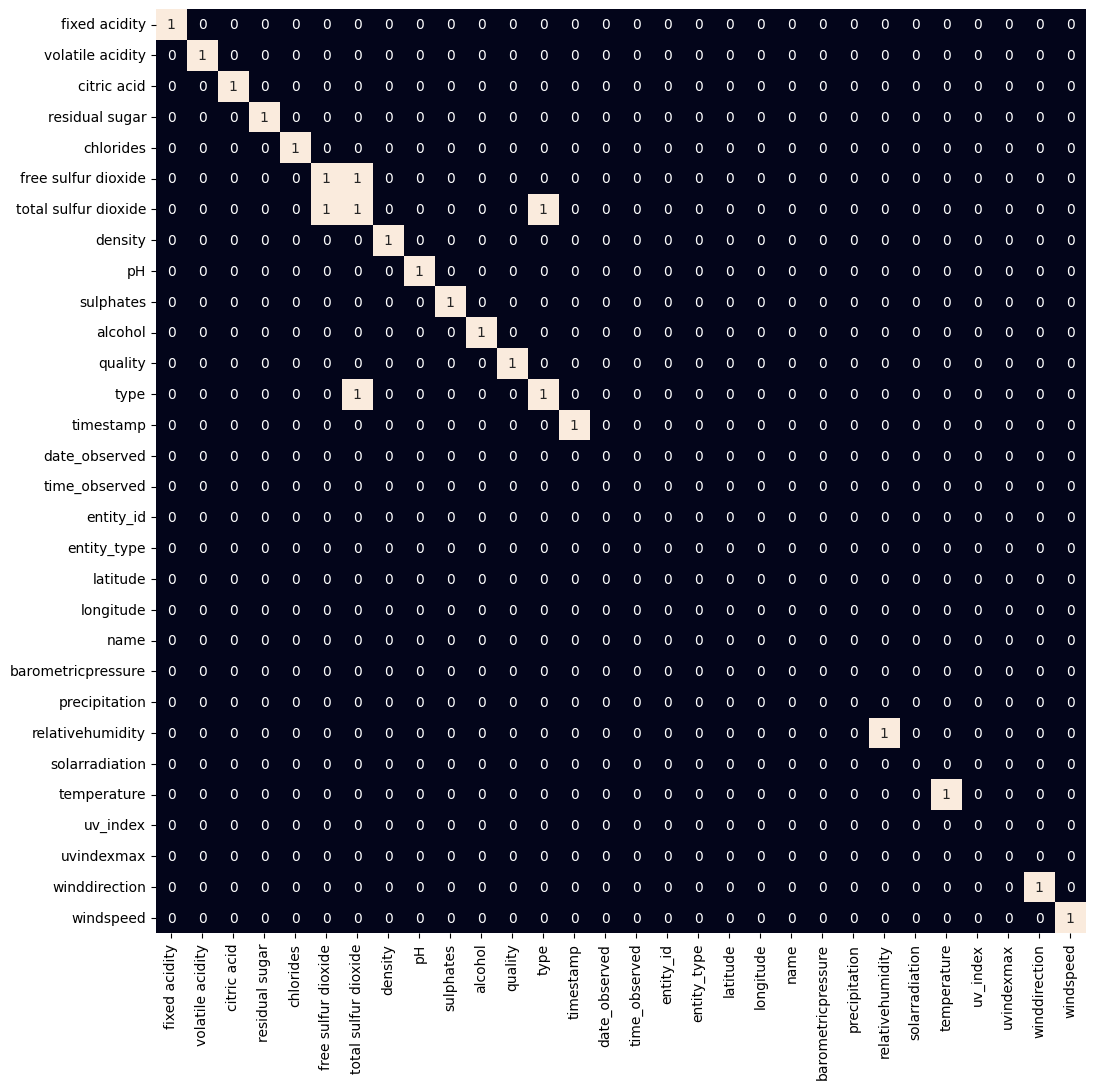

In [308]:
# Convert 'object' columns to numerical if they represent numbers
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace non-convertibles with NaN
        except:
            pass  # Skip columns that cannot be converted

plt.figure(figsize=(12, 12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [309]:
# Drop unnecessary columns (adjust based on your analysis)
df.drop(columns=['entity_id', 'entity_type', 'name', 'latitude', 'longitude', 'date_observed', 'time_observed', 'barometricpressure', 'uv_index'], inplace=True)

# Extract year, month, and day (optional: use month to analyze growing season)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

df.drop(columns=['timestamp'], inplace=True)

In [310]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,type,precipitation,relativehumidity,solarradiation,temperature,uvindexmax,winddirection,windspeed,year,month
0,6.3,0.260,0.49,1.5,0.052,34.0,134.0,0.99240,2.99,0.61,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
1,7.2,0.210,0.36,15.7,0.045,68.0,183.0,0.99922,3.25,0.76,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
2,7.9,0.110,0.49,4.5,0.048,27.0,133.0,0.99460,3.24,0.42,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
3,8.2,0.180,0.49,1.1,0.033,28.0,81.0,0.99230,3.00,0.68,...,1,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9
4,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.99940,3.51,0.72,...,0,0.0,0.89,0.0,14.5,0.0,226.0,1.78816,2024,9


In [311]:
# # Train XGBoost to check feature importance
# xgb_model = xgb.XGBClassifier().fit(xtrain, ytrain)
# importances = pd.Series(xgb_model.feature_importances_, index=features.columns)

# # Plot feature importance
# importances.sort_values().plot(kind='barh', figsize=(10,6))
# plt.show()

In [312]:
df = df.drop('total sulfur dioxide', axis=1)
df['best quality'] = [1 if x > 5 else 0 for x in df.quality]

In [313]:
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

xtrain, xtest, ytrain, ytest = train_test_split(
	features, target, test_size=0.2, random_state=40)

# Impute missing values after splitting

imputer = SimpleImputer(strategy='mean')  # Or another strategy like 'median'
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

xtrain.shape, xtest.shape

((5197, 20), (1300, 20))

In [314]:
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

# Define models (Added Random Forest & Gradient Boosting)
models = [
    LogisticRegression(),
    XGBClassifier(),
    SVC(kernel='rbf'),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42)
]

# Train and evaluate each model
for model in models:
    model.fit(xtrain, ytrain)

    # Model predictions
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluation Metrics
    print(f'{model.__class__.__name__}:')
    print('Training Accuracy:', metrics.accuracy_score(ytrain, ytrain_pred))
    print('Validation Accuracy:', metrics.accuracy_score(ytest, ytest_pred))
    print('ROC AUC (Train):', metrics.roc_auc_score(ytrain, ytrain_pred))
    print('ROC AUC (Test):', metrics.roc_auc_score(ytest, ytest_pred))
    print('Classification Report:')
    print(metrics.classification_report(ytest, ytest_pred))
    print('-' * 50)


LogisticRegression:
Training Accuracy: 0.7373484702713103
Validation Accuracy: 0.7584615384615384
ROC AUC (Train): 0.6984927064646234
ROC AUC (Test): 0.7202624090321352
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       467
           1       0.79      0.86      0.82       833

    accuracy                           0.76      1300
   macro avg       0.74      0.72      0.73      1300
weighted avg       0.75      0.76      0.75      1300

--------------------------------------------------
XGBClassifier:
Training Accuracy: 0.9926880892822783
Validation Accuracy: 0.8023076923076923
ROC AUC (Train): 0.9916060727508683
ROC AUC (Test): 0.7794085514291369
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       467
           1       0.84      0.86      0.85       833

    accuracy                           0.80      1300
   macro avg       0.79  

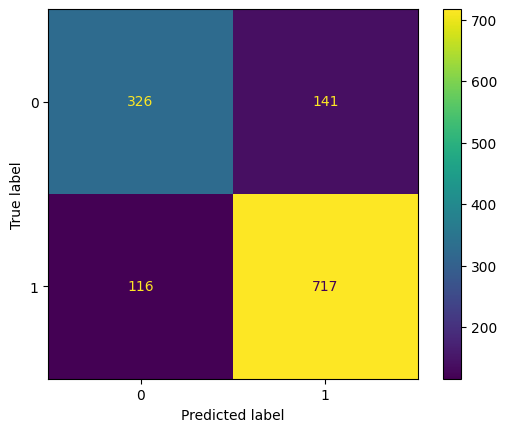

In [315]:
# Confusion Matrix for the best model (e.g., XGBClassifier)
best_model = models[1]  # Choose based on evaluation results
cm = confusion_matrix(ytest, best_model.predict(xtest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

In [316]:
print(metrics.classification_report(ytest,
models[1].predict(xtest)))


              precision    recall  f1-score   support

           0       0.74      0.70      0.72       467
           1       0.84      0.86      0.85       833

    accuracy                           0.80      1300
   macro avg       0.79      0.78      0.78      1300
weighted avg       0.80      0.80      0.80      1300



In [316]:
# To predict wine quality using weather conditions like temperature, you need to ensure that the weather data is included in your feature set (features). Since you've already combined the wine quality dataset with the weather dataset, the weather variables (e.g., temperature, humidity, etc.) should already be part of your features.

# Here’s how you can proceed:

# 1. Ensure Weather Data is Included in Features
# Make sure your features DataFrame includes the weather-related columns (e.g., temperature, relativehumidity, windspeed, etc.). For example:

# python
# Copy
# # Assuming combined_df is your combined dataset
# features = combined_df.drop(['quality', 'best quality', 'timestamp', 'entity_id'], axis=1)  # Drop irrelevant columns
# target = combined_df['best quality']
# 2. Train-Test Split and Preprocessing
# You’ve already done this step correctly. Just ensure that the weather-related features are included in xtrain and xtest.

# python
# Copy
# from sklearn.model_selection import train_test_split
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import MinMaxScaler

# # Train-test split
# xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=40)

# # Impute missing values
# imputer = SimpleImputer(strategy='mean')  # Or another strategy like 'median'
# xtrain = imputer.fit_transform(xtrain)
# xtest = imputer.transform(xtest)

# # Normalize/scale features
# norm = MinMaxScaler()
# xtrain = norm.fit_transform(xtrain)
# xtest = norm.transform(xtest)
# 3. Train Models
# You’ve already defined and trained multiple models. These models will now use the weather-related features (e.g., temperature) to predict wine quality.

# python
# Copy
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn import metrics

# # Define models
# models = [
#     LogisticRegression(),
#     XGBClassifier(),
#     SVC(kernel='rbf'),
#     RandomForestClassifier(n_estimators=100, random_state=42),
#     GradientBoostingClassifier(n_estimators=100, random_state=42)
# ]

# # Train and evaluate each model
# for model in models:
#     model.fit(xtrain, ytrain)

#     # Model predictions
#     ytrain_pred = model.predict(xtrain)
#     ytest_pred = model.predict(xtest)

#     # Evaluation Metrics
#     print(f'{model.__class__.__name__}:')
#     print('Training Accuracy:', metrics.accuracy_score(ytrain, ytrain_pred))
#     print('Validation Accuracy:', metrics.accuracy_score(ytest, ytest_pred))
#     print('ROC AUC (Train):', metrics.roc_auc_score(ytrain, ytrain_pred))
#     print('ROC AUC (Test):', metrics.roc_auc_score(ytest, ytest_pred))
#     print('Classification Report:')
#     print(metrics.classification_report(ytest, ytest_pred))
#     print('-' * 50)
# 4. Predict Wine Quality for New Weather Conditions
# To predict wine quality for new weather conditions, you need to:

# Create a new input DataFrame with the weather conditions (e.g., temperature, humidity, etc.).

# Preprocess the input data (imputation and scaling) using the same imputer and norm objects.

# Use the trained model to make predictions.

# Example:
# python
# Copy
# # New weather conditions (example)
# new_weather_data = {
#     'fixed acidity': [7.4],
#     'volatile acidity': [0.7],
#     'citric acid': [0.0],
#     'residual sugar': [1.9],
#     'chlorides': [0.076],
#     'free sulfur dioxide': [11.0],
#     'total sulfur dioxide': [34.0],
#     'density': [0.9978],
#     'pH': [3.51],
#     'sulphates': [0.56],
#     'alcohol': [9.4],
#     'temperature': [20.0],  # Example temperature
#     'relativehumidity': [70.0],  # Example humidity
#     'windspeed': [5.0]  # Example wind speed
# }

# # Convert to DataFrame
# new_data = pd.DataFrame(new_weather_data)

# # Preprocess the new data (imputation and scaling)
# new_data = imputer.transform(new_data)  # Use the same imputer
# new_data = norm.transform(new_data)  # Use the same scaler

# # Predict using the best model (e.g., RandomForestClassifier)
# best_model = RandomForestClassifier(n_estimators=100, random_state=42)
# best_model.fit(xtrain, ytrain)  # Ensure the model is trained
# predicted_quality = best_model.predict(new_data)

# print('Predicted Wine Quality:', predicted_quality)
# 5. Interpret Results
# The predicted_quality will be the output of your model (e.g., 0 or 1 for binary classification, or a numerical value for regression).

# You can also use predict_proba (for classification models) to get the probability of each class.

# 6. Key Considerations
# Feature Importance: Use techniques like SHAP or feature importance from the model to understand which weather variables (e.g., temperature) are most influential in predicting wine quality.

# Model Selection: Choose the best-performing model based on validation metrics (e.g., accuracy, ROC AUC).

# Data Quality: Ensure the new weather data is in the same format and scale as the training data.